# In this ipython notebook we will consider our method of constructing nonlinear interactions. We examine the resulting terms and confirm they have the expected behavior.

In [1]:
import Roots
import Potapov
import Examples
import Time_Sims
import functions
import tests

import numpy as np
import numpy.linalg as la
from scipy.integrate import ode

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def contour_plot(Mat,func = abs):
    '''
    Make a simple plot to view a matrix

    Args:
        Mat (compelx-valued matrix): a matrix to view
        func (optional[function]): a function to apply to each component

    Generates a plot of the matrix.
    '''
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(func(Mat), interpolation='nearest')
    fig.colorbar(cax)
    plt.show()


In [86]:
Ex = Examples.Example3(r1 = 0.7, r3 = 0.7, max_linewidth=35.)
Ex.run_Potapov()
E = Ex.E
roots = Ex.roots
M1 = Ex.M1
delays = Ex.delays
modes = functions.spatial_modes(roots,M1,E)

In [87]:
vecs = Ex.vecs

In [88]:
roots

[(-1.2178438327806838-32.542503045139362j),
 (-1.2178438327806846+32.542503045139362j),
 (-1.2361423847570387+10.901754569501422j),
 (-1.1431816829945924-1.669322534095661e-124j),
 (-1.2361423847570385-10.901754569501421j),
 (-1.1867857239576909+53.731290378625815j),
 (-1.1714495298385854+40.60438955513678j),
 (-1.1500606861696618+20.178105255320492j),
 (-1.1867857239576904-53.731290378625815j),
 (-1.1714495298385854-40.60438955513678j),
 (-1.1500606861696618-20.178105255320492j)]

In [89]:
root_z = lambda z: 1j*z  ## a fake root we will vary

In [90]:
roots_to_use = lambda z: [root_z(z),roots[-1],roots[-2]]

In [91]:
modes_to_use = [modes[-1],modes[-1], modes[4]]

In [92]:
delay_indices = 0

In [93]:
plus_or_minus_arr =  [-1,-1,-1]

In [94]:
x = np.linspace(-300,260,1000)

In [95]:
f = lambda z: functions.make_nonlinear_interaction(roots_to_use(z),modes_to_use,Ex.delays,0,0,0.1,plus_or_minus_arr)

In [96]:
### by default, indices_of_refraction=[1,1,1]

We will vary the fake root we introduced to obtain the phase-mismatch diagram. That is, the phase mismatch $\delta k$ is going to be some linear function of $z$.

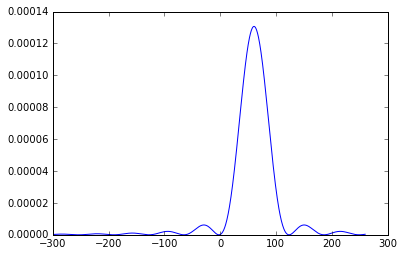

In [97]:
plt.plot(x, [abs(f(z))**2 for z in x])

What happens when we change the indices of refraction for the different modes? The phase-mismatch will shift depending on where the new $\delta k = 0$ occurs. The width of the peak may also change if the indices of refraction are large.

In [98]:
indices_of_refraction=[3.,1.1,2.]

In [99]:
f = lambda z: functions.make_nonlinear_interaction(roots_to_use(z),
                modes_to_use,Ex.delays,0,0,0.1,plus_or_minus_arr,indices_of_refraction=indices_of_refraction)

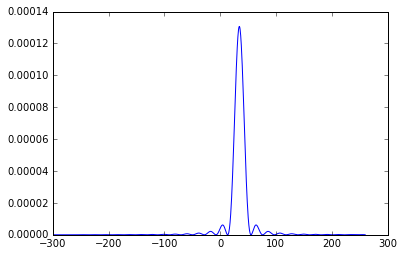

In [100]:
plt.plot(x, [abs(f(z))**2 for z in x])

# Generating a Hamiltonian from  a model

 In this section we will use example 3 to generate a Hamiltonian with nonlinaer coefficients resulting when inserting a nonlinearity in a circuit. We will assume that the nonlinearity is inserting at the delay line of index 0 corresponding to $\tau_1$.

In [101]:
import sympy as sp
import itertools
from qnet.algebra.circuit_algebra import *

In [102]:
Ex = Examples.Example3(r1 = 0.9, r3 = 0.9, max_linewidth=35.,max_freq=25.)
Ex.run_Potapov()
E = Ex.E
roots = Ex.roots
M1 = Ex.M1
delays = Ex.delays
modes = functions.spatial_modes(roots,M1,E)

In [103]:
roots

[(-0.36514939263783186-10.901513851604911j),
 (-0.33972600185569823+20.178467995423109j),
 (-0.36514939263783186+10.901513851604911j),
 (-0.33972600185569823-20.17846799542311j),
 (-0.3376937738186606-4.1474624048492497e-23j)]

In [104]:
## nonlinearity information

delay_index = 0 
start_nonlin = 0.
duration_nonlin = .1

In [105]:
m = len(roots)

In [106]:
indices = range(m)

In [107]:
chi_order = 3  ## i.e. chi-3 nonlinearity

In [985]:
plus_minus_combinations = list(itertools.combinations(range(chi_order + 1), 2))  ## pick which fields are annihilated

In [986]:
list_of_pm_arr = []
for tup in plus_minus_combinations:
    ls = [1]*(chi_order+1)
    for i in tup:
        ls[i]=-1
    list_of_pm_arr.append(ls)

In [987]:
a = [sp.symbols('a_'+str(i)) for i in range(m)]
a_H = [sp.symbols('a^H_'+str(i)) for i in range(m)]

In [988]:
A,B,C,D = Potapov.get_Potapov_ABCD(Ex.roots,Ex.vecs,Ex.T,z=0.)

In [989]:
#Omega = (A-A.H)/(2j) #### closed dynamics only. i.e. not damping

In [990]:
Omega = -1j*A  ## full dynamics

In [991]:
H_lin_sp = 0
## with sympy only
for i in range(m):
    for j in range(m):
        H_lin_sp += a_H[i]*a[j]*Omega[i,j]

In [992]:
def make_nonlin_term_sp(combination,pm_arr):
    '''
    Make symbolic term
    With sympy only
    '''
    r = 1
    for index,sign in zip(combination,pm_arr):
        if sign == 1:
            r*= a_H[index]
        else:
            r *= a[index]
    return r

Let's impose a large 'index of refraction'. In the future we will replaces this by better conditions for phase-mismatch, including realistic values. For now, this will narrow the gain versus $\Delta k$ function so that few interaction terms remain.

In [993]:
def weight(combination,pm_arr):
    roots_to_use = np.array([roots[i] for i in combination])
    modes_to_use = [modes[i] for i in combination]
    return functions.make_nonlinear_interaction(roots_to_use, modes_to_use, delays, delay_indices,
                                start_nonlin,duration_nonlin,pm_arr,
                                indices_of_refraction = [1000.]*len(combination),
                                eps=1e-12,func=lambda z : z.imag)

In [994]:
## TODO: add a priori check to restrict exponential growth
weights = {}

In [995]:
count = 0

for pm_arr in list_of_pm_arr:
    field_combinations = itertools.combinations_with_replacement(range(m), chi_order+1)
    for combination in field_combinations:
        count += 1
        weights[tuple(combination),tuple(pm_arr)] = weight(combination,pm_arr)        
print count

420


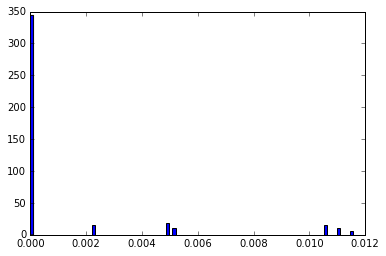

In [996]:
plt.hist([abs(x) for x in [weights[key] for key in weights] ],bins=100);

As we see above, most of the interactions are negligible. Let's drop them out.

In [997]:
significant_weight_keys = [key for key in weights if abs(weights[key]) > 1e-4]

In [998]:
significant_weights = dict((key,weights[key]) for key in significant_weight_keys)

In [999]:
significant_weights =  {k:v for k,v in weights.iteritems() if abs(v) > 1e-4} ## more elegant 

In [1000]:
len(significant_weights)

In [1001]:
H_nonlin_sp = 0  ## with sympy only

for combination,pm_arr in significant_weights:
    H_nonlin_sp += make_nonlin_term_sp(combination,pm_arr)*significant_weights[combination,pm_arr]

In [1002]:
H_sp = H_lin_sp+H_nonlin_sp*0.

In [1003]:
def make_eq_motion(H_sp):
    '''
    Input is a tuple or list, output is a matrix vector
    '''
    diff_ls = [1j*sp.diff(H_sp,var) for var in a_H] + [-1j*sp.diff(H_sp,var) for var in a]
    fs = [sp.lambdify( tuple(a+a_H),expression) for expression in diff_ls ]
    return lambda arr: (np.asmatrix([ f(* arr ) for f in fs])).T

In [1004]:
    eq_mot = make_eq_motion(H_sp)

In [1005]:
def double_up(M1,M2=None):
    if M2 == None:
        M2 = np.zeros_like(M1)
    top = np.hstack([M1,M2])
    bottom = np.hstack([np.conj(M2),np.conj(M1)])
    return np.vstack([top,bottom])

In [1006]:
A_d,C_d,D_d = map(double_up,(A,C,D))

In [1007]:
B_d = -double_up(C.H)

In [1008]:
def make_f(eq_mot,B,a_in):
    '''
    Nonlinear equations of motion
    '''
    return lambda t,a: np.asarray(eq_mot(a)+B_d*a_in(t)).T[0]

In [1009]:
def make_f_lin(A,B,a_in):
    '''
    Linear equations of motion
    '''
    return lambda t,a: np.asarray(A*np.asmatrix(a).T+B*a_in(t)).T[0]

In [1010]:
a_in = lambda t: np.asmatrix([1.]*4).T

In [1011]:
f = make_f(eq_mot,B_d,a_in)

In [1012]:
f_lin = make_f_lin(A_d,B_d,a_in)

In [1013]:
A_d*np.asmatrix([1.]*10).T - eq_mot([1.]*10)

matrix([[  3.88578059e-16 +0.00000000e+00j],
        [ -8.88178420e-16 -1.06581410e-14j],
        [  2.77555756e-16 +8.88178420e-15j],
        [ -2.22044605e-16 +3.55271368e-15j],
        [  0.00000000e+00 -1.24344979e-14j],
        [ -1.94365619e+00 -2.26249692e-04j],
        [ -1.90121217e+00 -4.91437988e-02j],
        [ -1.46052601e+00 +4.50430044e-01j],
        [ -1.90489890e+00 +4.86594824e-02j],
        [ -1.46064686e+00 -4.49719478e-01j]])

In [1014]:
f(0,[1.]*10)

array([-0.57832011 -7.18271815e-17j, -1.25534698 -2.00288605e+01j,
       -1.54658928 +1.03481475e+01j, -1.81789241 +2.01536995e+01j,
       -2.25694247 -1.02986758e+01j,  1.36533608 +2.26249692e-04j,
        0.64586519 +2.00780043e+01j, -0.08606327 -1.07985775e+01j,
        0.08700649 -2.02023590e+01j, -0.79629561 +1.07483952e+01j])

In [1015]:
f_lin(0,[1.]*10)

array([-0.57832011 -7.18271815e-17j, -1.25534698 -2.00288605e+01j,
       -1.54658928 +1.03481475e+01j, -1.81789241 +2.01536995e+01j,
       -2.25694247 -1.02986758e+01j, -0.57832011 +7.18271815e-17j,
       -1.25534698 +2.00288605e+01j, -1.54658928 -1.03481475e+01j,
       -1.81789241 -2.01536995e+01j, -2.25694247 +1.02986758e+01j])

In [1016]:
r = ode(f).set_integrator('zvode', method='bdf')
r_lin = ode(f_lin).set_integrator('zvode', method='bdf')

In [1017]:
y0 = np.asmatrix([0.]*10).T
t0=0.

In [1018]:
r.set_initial_value(y0, t0)
r_lin.set_initial_value(y0, t0)

In [1019]:
t1 = 15
dt = 0.01

In [1020]:
Y = []

while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    u = a_in(r.t)
    Y.append(C_d*r.y+D_d*u)

In [1021]:
Y_lin = []

while r_lin.successful() and r_lin.t < t1:
    r_lin.integrate(r_lin.t+dt)
    u = a_in(r_lin.t)
    Y_lin.append(C_d*r_lin.y+D_d*u)

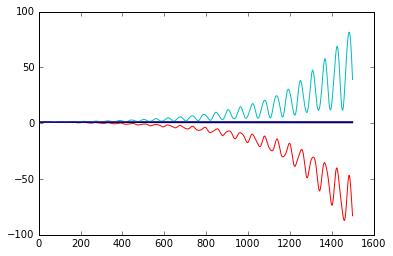

In [1022]:
for i in range(4):
    plt.plot([(y).real[i][0,0] for y in Y ])
    
for i in range(4):
    plt.plot([(y).real[i][0,0] for y in Y_lin ])

#### When Making the nonlinear terms above zero, we find agreement with the linear equtions of motion.

Using the symbolic packages is kind of slow. For classical simulations maybe we can avoid that. We just need to extract the equations of motion, which should end up being sparse in the interaction terms.

TODO: implement without sympy, e.g. with Julia

# ##############################

# Testing different cases with make_nonlinear_interaction

making sure different exceptions get caught

In [206]:
roots_to_use = np.array([roots[i] for i in combination])
modes_to_use = [modes[i] for i in combination]

In [207]:
def call_make_non_lin():
    return functions.make_nonlinear_interaction(roots_to_use, modes_to_use, delays, delay_indices,
                            start_nonlin,duration_nonlin,pm_arr,
                            indices_of_refraction,
                            eps=1e-12,func=lambda z : z.imag)

In [208]:
call_make_non_lin()

(0.0021779902481650101+0.0036737045407247908j)

In [209]:
indices_of_refraction = 1000.
call_make_non_lin()

(0.0051419161593478663+0j)

In [210]:
start_nonlin = -1  ## this shouldn't happen
call_make_non_lin()

Exception: each element of start_nonlin must be greater than 0.

In [211]:
start_nonlin = [1]*len(roots_to_use)
call_make_non_lin()

Exception: duration_nonlin + start_loc must be less than the delay of index delay_index for start_loc in start_nonlin and delay_index in delay_indices.

In [212]:
start_nonlin = 0.00001
duration_nonlin = .099
call_make_non_lin()

(0.0050904969977543877+0j)

In [213]:
start_nonlin = [0.00001]*len(roots_to_use)
duration_nonlin = .099
call_make_non_lin()

(0.0050904969977543877+0j)

## Unused methods below

In [131]:
## consolidated weights do not take into account which modes are createad or annihilated.

consolidated_weightes = {}
for key in significant_weights:
    if not key[0] in consolidated_weightes:
        consolidated_weightes[key[0]] = significant_weights[key]
    else:
        consolidated_weightes[key[0]] += significant_weights[key]

'\nconsolidated_weightes = {}\nfor key in significant_weights:\n    if not key[0] in consolidated_weightes:\n        consolidated_weightes[key[0]] = significant_weights[key]\n    else:\n        consolidated_weightes[key[0]] += significant_weights[key]\n'

In [ ]:
## QNET annihilation and creation operators

a_ = [Destroy(local_space('fock', namespace = str(i))) for i in range(m)]

In [ ]:
## Make linear Hamiltonian with QNET

H_lin = sum([a_[i].dag()*a_[i]*Omega[i,i] for i in range(m)])  ## with QNET
def make_nonlin_term(combination,pm_arr):
    '''
    Make symbolic term
    With QNET
    '''
    r = 1
    for index,sign in zip(combination,pm_arr):
        if sign == 1:
            r*= a_[index].dag()
        else:
            r *= a_[index]
    return r

In [ ]:
## Make nonlinear Hamiltonian in QNET 

H_nonlin = 0  ## with QNET

for combination,pm_arr in significant_weights:
    H_nonlin += make_nonlin_term(combination,pm_arr)*significant_weights[combination,pm_arr]
    
H_qnet = H_lin+H_nonlin